In [1]:
!pip install qkeras
!pip install tensorflow==2.12.0 # 

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.4 MB/s eta 0:00:00
  Created wheel for pyparser: filename=pyparser-1.0-py3-none-any.whl size=4914 sha256=c3b0340d6eb0b5c42f54a3d27825dacf33673d8cb3b082a956b8ec73b8328fd5
  Stored in directory: /root/.cache/pip/wheels/65/48/69/eebe8cde4e13253d3c40be9bc8a9fae185922324be84233f7f
  Created wheel for parse: filename=parse-1.6.5-py3-none-any.whl size=18156 sha256=899d21ab347b34907041640e6a12661f2ebba0b4922b6df7d8cd8af76cb56982
  Stored in directory: /root/.cache/pip/wheels/e7/e6/a0/9d6031f45532f6cea3b5f1d66417d0a0f842c42da1f076281c
Successfully built pyparser parse
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine wh

# # Load CIFAR-10 data

In [2]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_val, y_val)=cifar10.load_data()

print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_val is {}'.format(x_val.shape)) 
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_val is {}'.format(y_val.shape))

170498071/170498071 [==============================] - 6s 0us/step
Shape of x_train is (50000, 32, 32, 3)
Shape of x_val is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_val is (10000, 1)


In [3]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

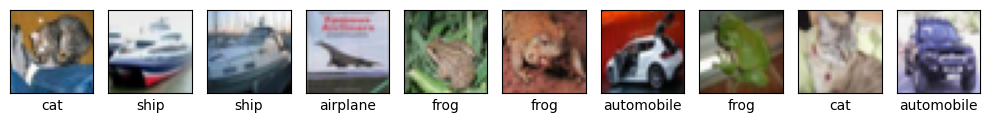

In [4]:
import matplotlib.pyplot as plt

# Plot first 10 test images with labels
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val[i])
    plt.xlabel(class_names[y_val[i][0]])
plt.tight_layout()
plt.show()

In [5]:
from tensorflow.keras.utils import to_categorical

# Normalizing
x_train=x_train/256.
x_val=x_val/256.

#One hot encoding
y_train_cat=to_categorical(y_train,10)
y_val_cat=to_categorical(y_val,10)

# Build the QKeras Model

Here, we will load the model from the original paper as our baseline.  
You may also build and train your own model.


In [6]:
LOAD_MODEL = False

In [7]:
# keras import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Activation, Flatten, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import Model

#qkeras import
from qkeras import QConv2DBatchnorm, QActivation, QDense 
from qkeras.autoqkeras.utils import print_qmodel_summary
from qkeras.utils import load_qmodel

In [8]:
model=Sequential()
model.add(Input(shape=(32,32,3)))
model.add(
    QConv2DBatchnorm(
        filters=24,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True
    )
)
model.add(QActivation('quantized_relu(6,0)'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(
    QConv2DBatchnorm(
        filters=24,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True
    )
)
model.add(QActivation('quantized_relu(6,0)'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(
    QDense(
        32,
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001)
    )
)
model.add(BatchNormalization())
model.add(QActivation('quantized_relu(6,0)'))

model.add(
    QDense(
        10,
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001)
    )
)

In [9]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])

In [10]:
history=model.fit(x_train,
                    y_train_cat,
                    #epochs=50,
                    epochs=5,
                    validation_data=(x_val,y_val_cat)
                   )

Epoch 1/5
1563/1563 [==============================] - 45s 27ms/step - loss: 1.7085 - accuracy: 0.4402 - val_loss: 1.9139 - val_accuracy: 0.3687
Epoch 2/5
1563/1563 [==============================] - 41s 26ms/step - loss: 1.4525 - accuracy: 0.5334 - val_loss: 1.5920 - val_accuracy: 0.4719
Epoch 3/5
1563/1563 [==============================] - 41s 26ms/step - loss: 1.3850 - accuracy: 0.5633 - val_loss: 1.4163 - val_accuracy: 0.5493
Epoch 4/5
1563/1563 [==============================] - 41s 26ms/step - loss: 1.3348 - accuracy: 0.5818 - val_loss: 1.6066 - val_accuracy: 0.4881
Epoch 5/5
1563/1563 [==============================] - 41s 26ms/step - loss: 1.2963 - accuracy: 0.5935 - val_loss: 1.6145 - val_accuracy: 0.4905


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_conv2d_batchnorm (QConv2D  (None, 30, 30, 24)       769       
 Batchnorm)                                                      
                                                                 
 q_activation (QActivation)  (None, 30, 30, 24)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 24)       0         
 )                                                               
                                                                 
 q_conv2d_batchnorm_1 (QConv  (None, 13, 13, 24)       5305      
 2DBatchnorm)                                                    
                                                                 
 q_activation_1 (QActivation  (None, 13, 13, 24)       0         
 )                                                      

In [12]:
print_qmodel_summary(model)

q_conv2d_batchnorm   f=24 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
q_activation         quantized_relu(6,0)
q_conv2d_batchnorm_1 f=24 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
q_activation_1       quantized_relu(6,0)
q_dense              u=32 quantized_bits(6,0,0,alpha=1) 
batch_normalization_2 is normal keras bn layer
q_activation_2       quantized_relu(6,0)
q_dense_1            u=10 quantized_bits(6,0,0,alpha=1) 



# Model Prediction Visualization

We use the model to predict labels for the first 10 test images. Each image is displayed along with:
- **GT**: Ground Truth label
- **PR**: Predicted label

In [13]:
import numpy as np

# Predict
y_pred_logits = model.predict(x_val[:10])  # predict on first 10 images
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = y_val[:10]

1/1 [==============================] - 0s 468ms/step


/tmp/ipykernel_31/969944031.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  title = f"GT:{class_names[int(y_true[i])]}\nPR:{class_names[y_pred[i]]}"


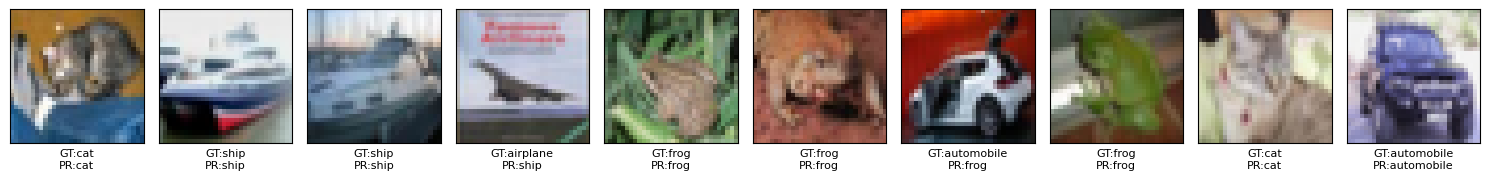

In [14]:
# Plot
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val[i])
    title = f"GT:{class_names[int(y_true[i])]}\nPR:{class_names[y_pred[i]]}"
    plt.xlabel(title, fontsize=8)
plt.tight_layout()
plt.show()

In [15]:
# Evaluate the Model accuracy on the entire CIFAR-10 Test Set

model.evaluate(x_val, y_val_cat, verbose=1)

313/313 [==============================] - 2s 7ms/step - loss: 1.6145 - accuracy: 0.4905


[1.6145247220993042, 0.49050000309944153]

# HLS Conversion

In [16]:
!pip install hls4ml==1.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.9 MB/s eta 0:00:0000:0100:01


In [17]:
import hls4ml
from pprint import pprint

In [18]:
config = hls4ml.utils.config_from_keras_model(model, 
                                              granularity='name', 
                                              backend='Vitis',
                                              default_precision='fixed<16,6>', # for batchnorm
                                              default_reuse_factor=224,                                 
                                             )

Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: q_conv2d_batchnorm, layer type: QConv2DBatchnorm, input shapes: [[None, 32, 32, 3]], output shape: [None, 30, 30, 24]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 30, 30, 24]], output shape: [None, 30, 30, 24]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 30, 30, 24]], output shape: [None, 15, 15, 24]
Layer name: q_conv2d_batchnorm_1, layer type: QConv2DBatchnorm, input shapes: [[None, 15, 15, 24]], output shape: [None, 13, 13, 24]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 13, 13, 24]], output shape: [None, 13, 13, 24]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 13, 13, 24]], output shape: [None, 6, 6, 24]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 6, 6, 24]], output shape: [None, 864]
Layer

In [19]:
pprint(config)

{'LayerName': {'batch_normalization_2': {'Precision': {'bias': 'auto',
                                                       'result': 'auto',
                                                       'scale': 'auto'},
                                         'ReuseFactor': 224,
                                         'Trace': False},
               'flatten': {'Precision': {'result': 'auto'}, 'Trace': False},
               'input_1': {'Precision': {'result': 'auto'}, 'Trace': False},
               'max_pooling2d': {'ConvImplementation': 'LineBuffer',
                                 'Precision': {'accum': 'auto',
                                               'result': 'auto'},
                                 'ReuseFactor': 224,
                                 'Trace': False},
               'max_pooling2d_1': {'ConvImplementation': 'LineBuffer',
                                   'Precision': {'accum': 'auto',
                                                 'result': 'auto'},
   

In [20]:
# Set the precision of the input layer to 8 bits
for layername in config['LayerName']:
    if layername.startswith('input'):
        config['LayerName'][layername]['Precision']['result'] = "ufixed<8,0>"


In [21]:
# Set the hls4ml strategy to Resource
config['Model']['Strategy'] = 'Resource'

In [22]:
pprint(config)

{'LayerName': {'batch_normalization_2': {'Precision': {'bias': 'auto',
                                                       'result': 'auto',
                                                       'scale': 'auto'},
                                         'ReuseFactor': 224,
                                         'Trace': False},
               'flatten': {'Precision': {'result': 'auto'}, 'Trace': False},
               'input_1': {'Precision': {'result': 'ufixed<8,0>'},
                           'Trace': False},
               'max_pooling2d': {'ConvImplementation': 'LineBuffer',
                                 'Precision': {'accum': 'auto',
                                               'result': 'auto'},
                                 'ReuseFactor': 224,
                                 'Trace': False},
               'max_pooling2d_1': {'ConvImplementation': 'LineBuffer',
                                   'Precision': {'accum': 'auto',
                                     

In [23]:
hls_path = "image_classification_hls_project"

In [24]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir=hls_path,
    backend = "Vitis",
    clock_period=5, 
    io_type = "io_stream", # same as paper
    part = "xc7z020clg400-1" # same as paper, PYNQ-Z2
)

Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: q_conv2d_batchnorm, layer type: QConv2DBatchnorm, input shapes: [[None, 32, 32, 3]], output shape: [None, 30, 30, 24]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 30, 30, 24]], output shape: [None, 30, 30, 24]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 30, 30, 24]], output shape: [None, 15, 15, 24]
Layer name: q_conv2d_batchnorm_1, layer type: QConv2DBatchnorm, input shapes: [[None, 15, 15, 24]], output shape: [None, 13, 13, 24]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 13, 13, 24]], output shape: [None, 13, 13, 24]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 13, 13, 24]], output shape: [None, 6, 6, 24]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 6, 6, 24]], output shape: [None, 864]
Layer

In [25]:
hls_model.compile()

Writing HLS project
Done


# HLS Model Prediction Visualization

We also use the hls model to predict labels for the first 10 test images. 

/tmp/ipykernel_31/1393192121.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  title = f"GT:{class_names[int(y_true[i])]}\nPR:{class_names[y_hls_pred[i]]}"


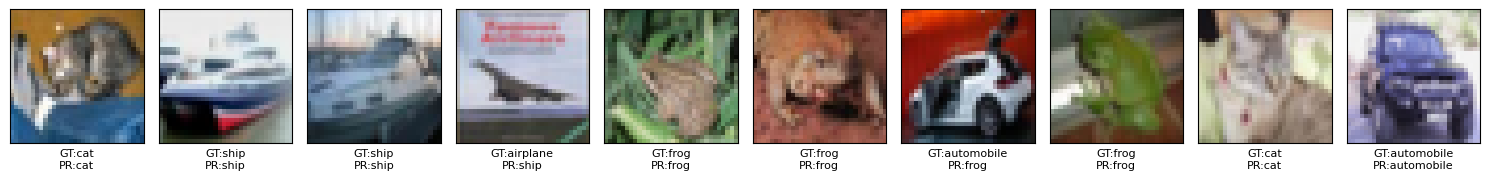

In [26]:
# Predict
y_hls_pred_logits = hls_model.predict(np.ascontiguousarray(x_val[:10]))  # predict on first 10 images
y_hls_pred = np.argmax(y_hls_pred_logits, axis=1)
y_true = y_val[:10]

# Plot
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val[i])
    title = f"GT:{class_names[int(y_true[i])]}\nPR:{class_names[y_hls_pred[i]]}"
    plt.xlabel(title, fontsize=8)
plt.tight_layout()
plt.show()

# Submission CSV File Generation

In [27]:
import pandas as pd
import numpy as np

# Load test data
test_data = np.load("/kaggle/input/fpga-challenge-qualifying-round/test_data.npy")
print(test_data.shape)

# Normalization
test_data = test_data/256.

(10000, 32, 32, 3)


In [28]:
# Compare Predictions: HLS Model vs. QKeras Model

test_sample_id = 0
test_sample = test_data[test_sample_id]
hls_prediction = hls_model.predict(np.expand_dims(test_sample, axis=0))
keras_prediction = model.predict(np.expand_dims(test_sample, axis=0))

print("HLS Model Prediction:", hls_prediction)
print("Keras Model Prediction:", keras_prediction)

1/1 [==============================] - 0s 19ms/step
HLS Model Prediction: [-2.33398438  2.34375    -1.75830078 -0.70117188 -0.78857422 -0.65820312
 -0.31494141 -1.4921875  -1.98925781  1.01611328]
Keras Model Prediction: [[-2.3336904   2.3439317  -1.7577133  -0.7007276  -0.7883902  -0.6579356
  -0.31420743 -1.491979   -1.9887842   1.0168394 ]]


In [29]:
from tqdm import tqdm

# Predict on all test data
# Note: This may take a while 

hls_prediction_all = []
hls_prediction_all_index = []
for data in tqdm(test_data):
    hls_pred = hls_model.predict(np.expand_dims(data, axis=0))
    hls_prediction_all.append(hls_pred)
    
    # Get the index of the class with the highest probability
    hls_pred_index = np.argmax(hls_pred, axis=-1)
    hls_prediction_all_index.append(hls_pred_index)

100%|██████████| 10000/10000 [04:32<00:00, 36.73it/s]


In [30]:
# Convert to numpy array
hls_prediction_all = np.stack(hls_prediction_all, axis=0)
hls_prediction_all_index = np.stack(hls_prediction_all_index, axis=0)

num_samples = len(hls_prediction_all_index)

# Create a DataFrame
submission_df = pd.DataFrame({
    "id": np.arange(num_samples),
    "label": hls_prediction_all_index  # Prediction Class Index
})


In [31]:
# Show the first 5 rows of the DataFrame
submission_df.head(5)

,id,label
0,0,1
1,1,6
2,2,8
3,3,1
4,4,3


In [32]:
# Save the submission file
submission_csv_path = "submissionv1.csv"
submission_df.to_csv(submission_csv_path, index=False)

print(f"Submission file saved: {submission_csv_path}")

Submission file saved: submissionv1.csv


# Generate Testbench Files and ZIP the HLS Project

We will use the first five test images to generate the testbench files.

In [33]:
# save testbench files for hls project
SAVE_BATCH = 5 # use 5 batch of test data
X_test_batch = test_data[:SAVE_BATCH]
y_hls_batch = hls_prediction_all[:SAVE_BATCH]


#write x_test to tb_input_features.dat
INPUT_FILE = hls_path + '/tb_data/tb_input_features.dat'
np.savetxt(INPUT_FILE, X_test_batch.reshape(X_test_batch.shape[0], -1), delimiter=' ', fmt='%6f') 

#write x_test to tb_input_features.dat
OUTPUT_FILE = hls_path + '/tb_data/tb_output_predictions.dat'
np.savetxt(OUTPUT_FILE, y_hls_batch.reshape(y_hls_batch.shape[0], -1), delimiter=' ', fmt='%6f')

# ZIP the HLS project

In [34]:
!zip -r {hls_path}.zip {hls_path}

  adding: image_classification_hls_project/ (stored 0%)
  adding: image_classification_hls_project/build_lib.sh (deflated 50%)
  adding: image_classification_hls_project/project.tcl (deflated 50%)
  adding: image_classification_hls_project/firmware/ (stored 0%)
  adding: image_classification_hls_project/firmware/ap_types/ (stored 0%)
  adding: image_classification_hls_project/firmware/ap_types/hls_math.h (deflated 66%)
  adding: image_classification_hls_project/firmware/ap_types/ap_fixed.h (deflated 84%)
  adding: image_classification_hls_project/firmware/ap_types/ap_fixed_ref.h (deflated 87%)
  adding: image_classification_hls_project/firmware/ap_types/ap_int_base.h (deflated 86%)
  adding: image_classification_hls_project/firmware/ap_types/ap_common.h (deflated 70%)
  adding: image_classification_hls_project/firmware/ap_types/hls_stream.h (deflated 63%)
  adding: image_classification_hls_project/firmware/ap_types/utils/ (stored 0%)
  adding: image_classification_hls_project/firmware/